In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from glimmer.model import train_neighbor_weights, set_seed
from glimmer.utils import spatial_smooth

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [7]:
# Set path
main_path = '/data/qiyu/spatialRegion/'
fig_path = main_path + 'figures/SVG/'
dir = main_path + 'data/slidetag/slidetag_tonsil'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Load data and train neighbor weights
seed = 42
set_seed(seed)

save_name = f"{dir}/rna_adata_latest.h5ad"
if os.path.exists(save_name):
    print('Loading adata')
    adata = sc.read_h5ad(save_name)
else:
    adata = sc.read_h5ad(os.path.join(dir, 'rna_adata.h5ad'))
    adata.obsm["spatial"] = pd.read_csv(os.path.join(dir, "coord.csv"), index_col=0).values
    sc.pp.normalize_total(adata, target_sum=1e4) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

    adata = train_neighbor_weights(
        adata, 
        feature_emb='X_pca', 
        spatial_emb='spatial', 
        k=50, 
        spatial_w=1, 
        log_barrier_w=1000, 
        sparisty_w=0.01,
        neighbor_weight=0.1, 
        num_epochs=10000, 
        cuda='cuda:1', 
        seed=seed, 
        batch=False, 
        batch_size = 2048
    )
    sc.pp.neighbors(adata, use_rep='X_emb_smooth', random_state=seed)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.3, random_state=seed)
    adata = spatial_smooth(adata, label_key='leiden')
    print('Weight mean', adata.obs['Weight'].mean())
    adata.write_h5ad(save_name)

Training: 100%|██████████| 10000/10000 [00:14<00:00, 679.97epoch/s, Loss: 17793.0511]


Weight mean 0.6923003


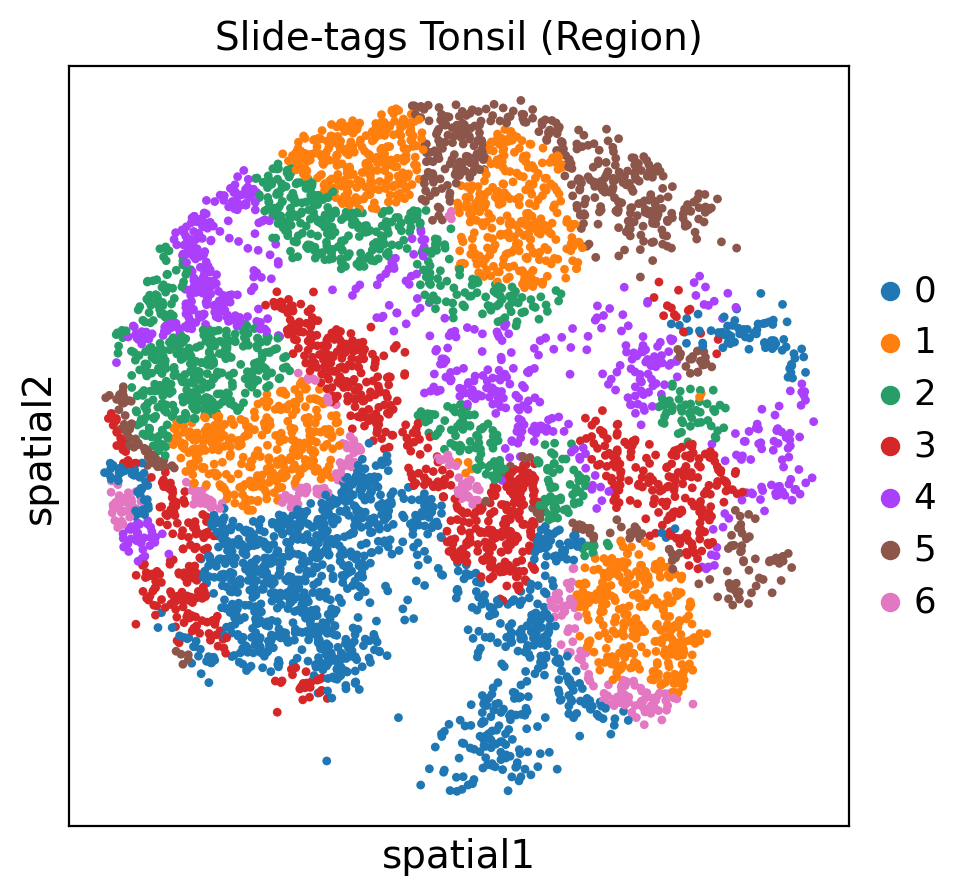

In [11]:
sc.settings.set_figure_params(dpi=100, figsize=(5, 5))
sc.pl.embedding(adata, basis='spatial', color='region', s=40, title="Slide-tags Tonsil (Region)", cmap='tab20') 

In [ ]:
# Load raw gene expression data
df = pd.read_csv(os.path.join(dir, 'genes.csv'), index_col=0)
adata_previous = sc.read_h5ad(os.path.join(dir, 'rna_adata_latest.h5ad'))
adata = ad.AnnData(X=df.values, 
                   obs=adata_previous.obs.copy(), 
                   var=pd.DataFrame(index=df.columns), 
                   uns=adata_previous.uns.copy(), 
                   obsm=adata_previous.obsm.copy())
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [21]:
# rename region
region_mapping = {
    '0': 'Marginal Zone',
    '1': 'Light Zone',
    '2': 'Dark Zone',
    '3': 'Paracortex',
    '4': 'Interfollicular Zone',
    '5': 'Marginal Zone',
    '6': 'Light Zone', 
}
region_order = [
    'Paracortex',
    'Interfollicular Zone',
    'Dark Zone',
    'Light Zone',
    'Marginal Zone',
]
custom_palette = [
    "#d62728", 
    "#9467bd",
    "#1f77b4",   
    "#ff7f0e",  
    "#279e68",
]
sc.settings.set_figure_params(dpi=100, figsize=(5, 5))
adata.obs['region_name'] = adata.obs['region'].map(region_mapping)
adata.obs['region_name'] = pd.Categorical(adata.obs['region_name'], categories=region_order, ordered=True)

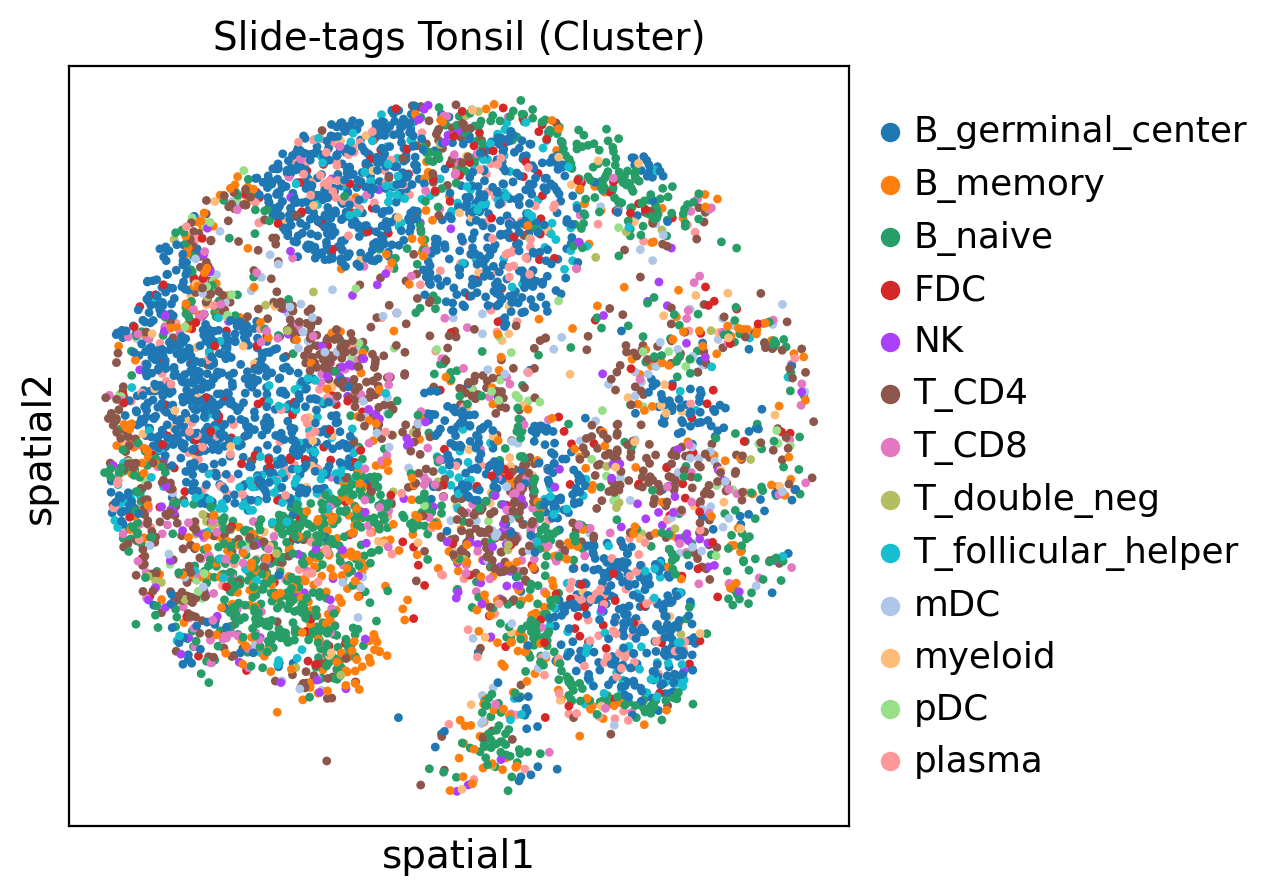

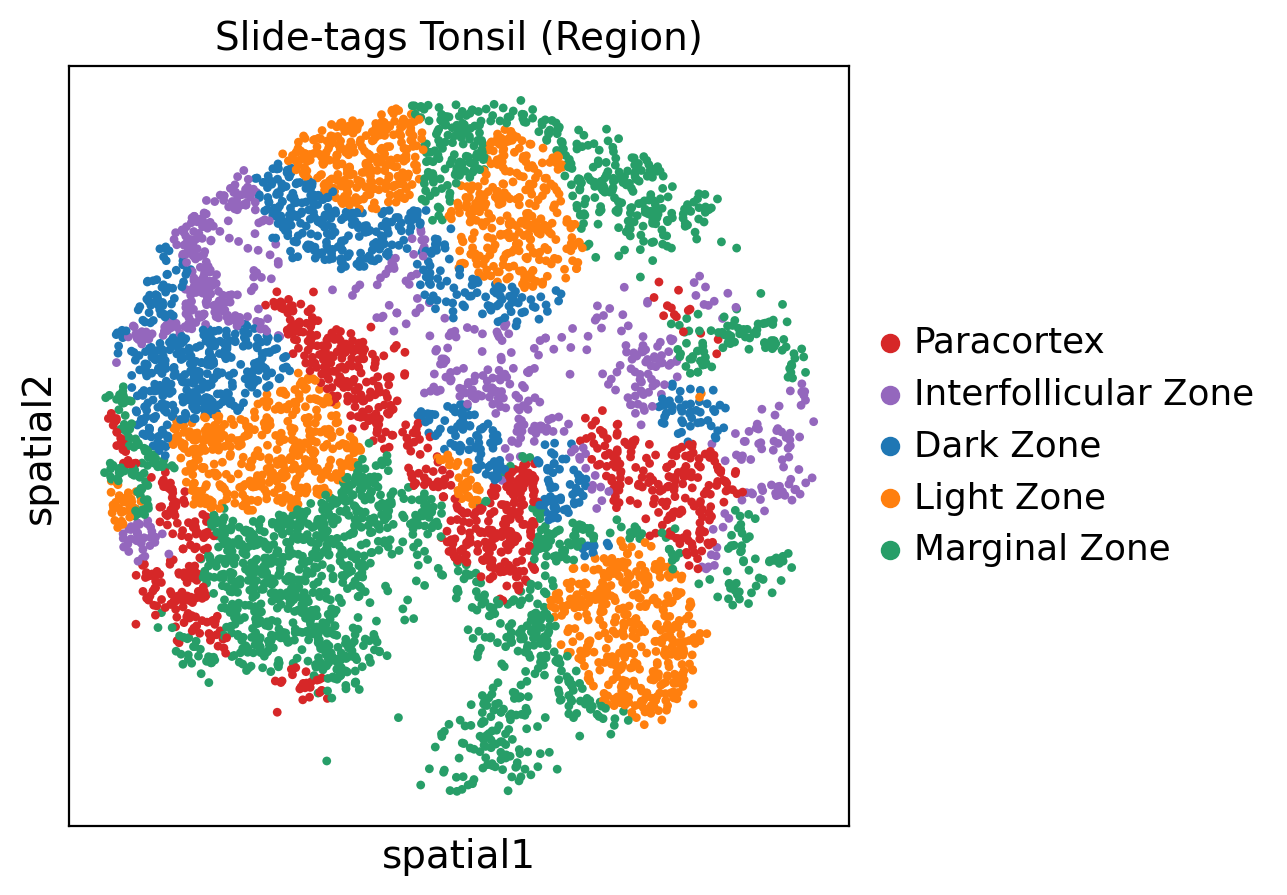

In [22]:
save_fig = True

# Slide-tags Tonsil (Cluster)
fig1 = sc.pl.embedding(adata, basis='spatial', color='cell_type', s=40, 
                       title="Slide-tags Tonsil (Cluster)", return_fig=True)
if save_fig:
    fig_name1 = fig_path + 'figure5/fig5_m_slidetag_tonsil_cluster.svg'
    fig1.savefig(fig_name1, format="svg", bbox_inches="tight")

# Slide-tags Tonsil (Region)
fig2 = sc.pl.embedding(adata, basis='spatial', color='region_name', s=40, palette=custom_palette, 
                       title="Slide-tags Tonsil (Region)", return_fig=True)
if save_fig:
    fig_name2 = fig_path + 'figure5/fig5_m_slidetag_tonsil_region.svg'
    fig2.savefig(fig_name2, format="svg", bbox_inches="tight")

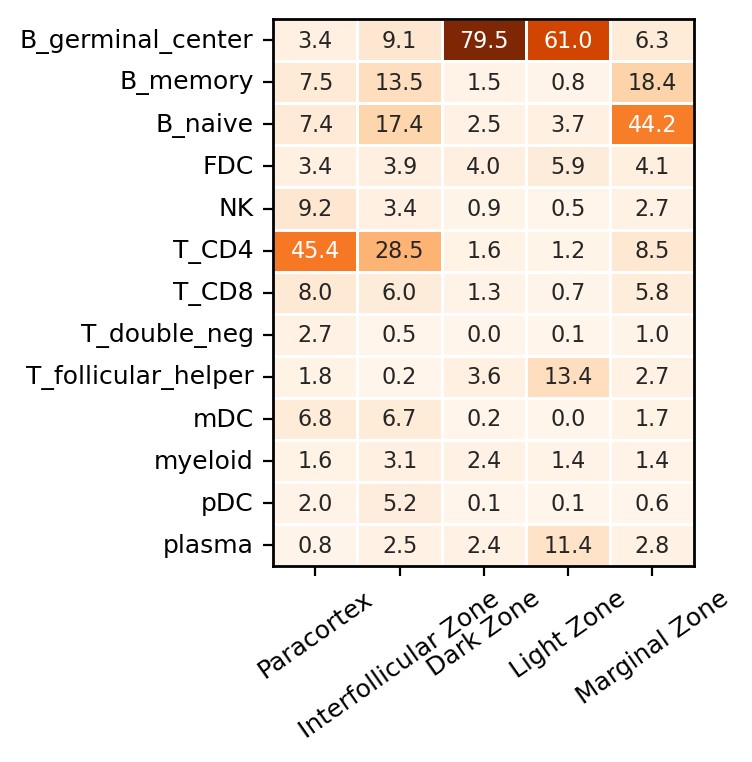

In [23]:
count_matrix = (
    adata.obs.groupby(["region_name", "cell_type"])
    .size()
    .unstack(fill_value=0) 
)
percent_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0) * 100  

# Plot heatmap
plt.figure(figsize=(2.7, 3.6))
ax = sns.heatmap(percent_matrix.T, cmap="Oranges", annot=True, fmt=".1f", linewidths=1, annot_kws={"size": 8}, cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=9, rotation=35)
ax.tick_params(axis="y", labelsize=9)
plt.grid(False) 
plt.title("")
for _, spine in ax.spines.items():
    spine.set_visible(True)  
    spine.set_linewidth(1) 
    spine.set_color("black") 
if save_fig:
    fig_name = fig_path + 'figure5/fig5_m_slidetag_tonsil_cluster_proportions.svg'
    plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show()

In [24]:
# DE Test
de_group = ['GCB', 'FDC', 'TFH'][0]
adata.obs["cell_type_by_region"] = adata.obs["cell_type"].astype(str) + "-" + adata.obs["region_name"].astype(str)
adata.obs["cell_type_by_region"] = adata.obs["cell_type_by_region"].astype("category")

# B_germinal_center 
if de_group == 'GCB':
    subset_clusters = ['B_germinal_center']
    lz_genes = ["CD83", "CXCL13", "POU2F2", "FCRL5", "CD74", "CIITA", "BTN2A2", "CD40", "CD86"]
    dz_genes = ["AICDA", "CXCR4", "FOXO1", "EZH2"]
    select_genes =  lz_genes + dz_genes
    log2fc_outlier = 17
    save_name = 'm_slidetag_tonsil_differential_genes_volcano_plot_GCB'
    fig_tittle = "GCB" 

# FDC
if de_group == 'FDC':
    subset_clusters = ['FDC']
    select_genes = ["FDCSP", "CLU"]
    log2fc_outlier = 12
    save_name = 's_slidetag_tonsil_differential_genes_volcano_plot_FDC'
    fig_tittle = "FDC" 

# T_follicular_helper
if de_group == 'TFH':
    subset_clusters = ['T_follicular_helper']
    lz_genes = ["HLA-C", "TAP1", "CXCR5", "ICAM1", "STAT5B", "IL21R", "ACO2", "TNFRSF14"]
    dz_genes = ["FTO",  "GPX2"]
    select_genes = lz_genes + dz_genes
    log2fc_outlier = 19
    save_name = 's_slidetag_tonsil_differential_genes_volcano_plot_TFH' 
    fig_tittle = "TFH" 

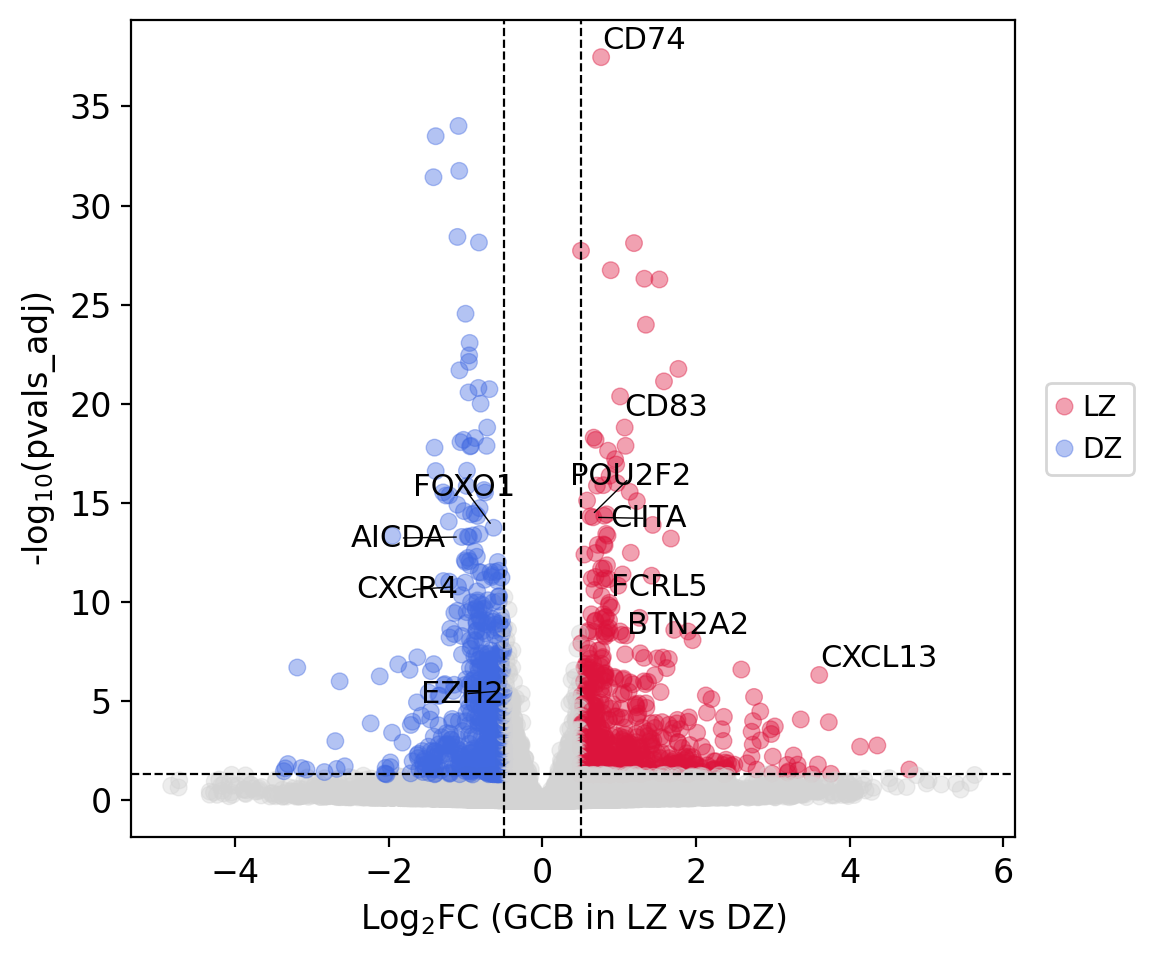

In [25]:
# DEG
groups = ["Dark Zone", "Light Zone"]
adata_subset = adata[adata.obs['cell_type'].isin(subset_clusters)].copy()
adata_subset = adata_subset[adata_subset.obs['region_name'].isin(groups)].copy()
sc.tl.rank_genes_groups(adata_subset, groupby='region_name', method='t-test_overestim_var', reference="Dark Zone")

# Data 
result = adata_subset.uns['rank_genes_groups']
de_df = pd.DataFrame({
    'gene': result['names']['Light Zone'],
    'logfc': result['logfoldchanges']['Light Zone'],
    'pvals': result['pvals_adj']['Light Zone']
})
log2fc_cutoff = 0.5
de_df = de_df[de_df['logfc'].abs() < log2fc_outlier].copy()
de_df['-log10(padj)'] = -np.log10(de_df['pvals'].replace(0, 1e-300))
de_df['significant'] = (de_df['pvals'] < 0.05) & (de_df['logfc'].abs() > log2fc_cutoff)

def zone_direction(row):
    if row['significant']:
        return 'DZ' if row['logfc'] < -log2fc_cutoff else 'LZ'
    else:
        return '' 
de_df['zone'] = de_df.apply(zone_direction, axis=1)
palette = {'LZ': 'crimson', 'DZ': 'royalblue', '': 'lightgrey'}
select_genes = de_df.loc[(de_df['significant']) & (de_df['gene'].isin(select_genes)), 'gene'].unique().tolist()
de_df['highlight'] = de_df['gene'].apply(lambda g: g if g in select_genes else '')

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=de_df, x='logfc', y='-log10(padj)', hue='zone', rasterized=True,
                palette=palette, edgecolor=None, alpha=0.4, legend='brief')
texts = []
for _, row in de_df[de_df['highlight'] != ''].iterrows():
    ha = 'right' if row['logfc'] < 0 else 'left'
    texts.append(plt.text(row['logfc'], row['-log10(padj)'], row['gene'], fontsize=11, ha=ha))
adjust_text(texts, force_text=100, force_points=0.1, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(log2fc_cutoff, color='black', linestyle='--', linewidth=0.8)
plt.axvline(-log2fc_cutoff, color='black', linestyle='--', linewidth=0.8)
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=0.8)
plt.grid(False)
plt.xlabel(f"Log$_2$FC ({fig_tittle} in LZ vs DZ)", fontsize=12)
plt.ylabel("-log$_{10}$(pvals_adj)", fontsize=12)
plt.title("")
plt.legend(title="", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
if save_fig:
    fig_name = fig_path + f'figure5/fig5_{save_name}.svg'
    plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show() 

In [15]:
r1_count = de_df[(de_df['zone'] == 'LZ') & (de_df['significant'] == True)].shape[0]
r2_count = de_df[(de_df['zone'] == 'DZ') & (de_df['significant'] == True)].shape[0]
print(f"LZ zone significant genes: {r1_count}")
print(f"DZ zone significant genes: {r2_count}")

LZ zone significant genes: 618
DZ zone significant genes: 662


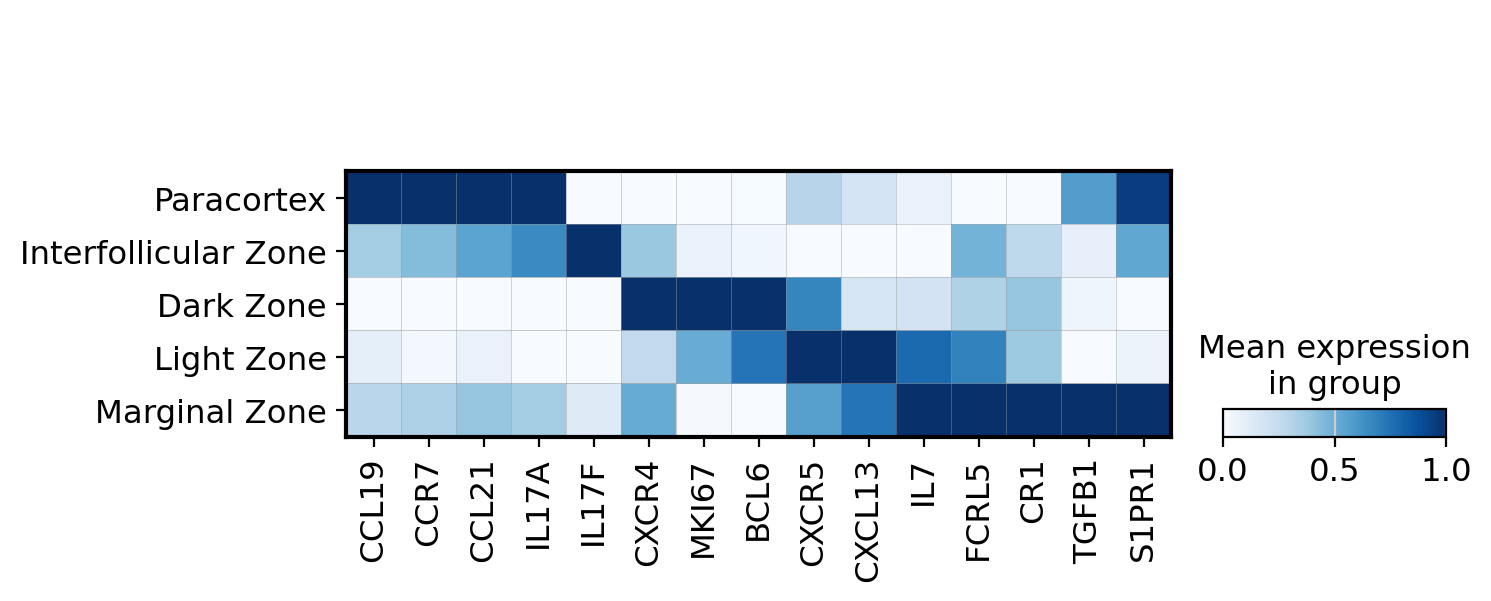

In [20]:
cytokine_genes_ordered = [
    "CCL19", "CCR7", "CCL21",           # Paracortex
    "IL17A", "IL17F",                   # Interfollicular Zone
    "CXCR4", "MKI67", "BCL6",           # Dark Zone
    "CXCR5", "CXCL13", "IL7",           # Light Zone
    "FCRL5", "CR1", "TGFB1", "S1PR1",   # Marginal Zone
]
cytokine_genes_filtered = list(set(cytokine_genes_ordered).intersection(adata.var_names))
cytokine_genes_final = sorted(cytokine_genes_filtered, key=lambda x: cytokine_genes_ordered.index(x) if x in cytokine_genes_ordered else float('inf'))
ax = sc.pl.matrixplot(adata, cytokine_genes_final, groupby='region_name', cmap='Blues', standard_scale='var', swap_axes=False, return_fig=True)
if save_fig:
    fig_name = fig_path + 'figure5/fig5_m_slidetag_tonsil_cytokine_expression.svg'
    ax.savefig(fig_name, format="svg", bbox_inches="tight")